In [117]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
from kinetics import rHDS, rHDN_NB, rHDN_B, rHDA

## Olhar Mederos 2006

In [118]:
#[0] = S

#[1] = NNB

#[2] = NB

#[3] = A

#[4] = H2

#[5] = H2S

#[6] = Np


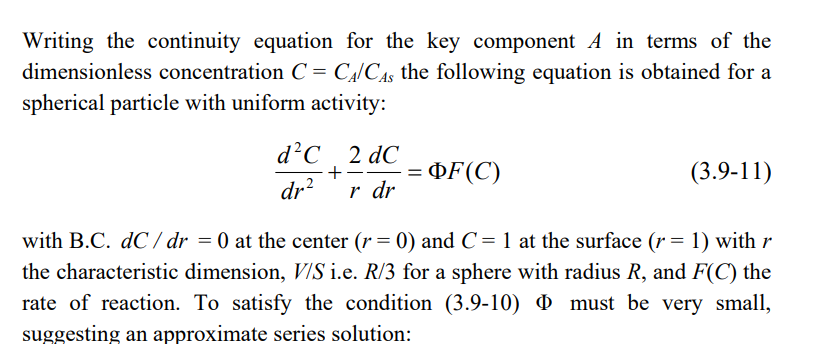

In [119]:
T = 380+273.15  #Temperature in K

P = 5.3e6 #Pressure in Pa

API = 22

Mm1 = 441.9 #molecuar weigth of the oil.

rhob = 0.8163 #bulk density in g/cm^3

uG = 0.28 #superficial gas velocity in cm/s

uL = 1.75e-2 #superficial liquid velocity in cm/s.

T_MeABP = (476 + 273.15)*1.8 # Mean average boiling point of oil in °R.

dp = 0.254 #equivalent diameter in cm

Vn = 8.3145*273.15/101325*1000 #Volume molar at standard conditions in Nl.

alfa1 = 7 #first coeficient of gas-liquid mass transfer in cm^(-1.6).

alfa2 = 0.4 #second coeficient of gas-liquid mass transfer

def specific_gravity(API):

    '''Get the specific gravity of oil.
    Parameters
    ----------
    API: int or float

    Returns
    -------
    The specific_gravity of oil.
    specific_gravity: float

    '''
    return 141.5/(API + 131.5)

roW = 999.007 #density of water at 15.6°C in kg/m^3.

d15_6 = specific_gravity(API)

rho0 = d15_6*roW #Specific gravity of oil.

vc1_m = 7.5214e-3*T_MeABP**0.2896*d15_6**(-0.7666) #critical specific volume in ft^3/lb.

vc_2 = 65.1 #critical specific volume of hydrogen in cm^3/mol.

vc_4 = 98.6 #critical specific volume of hydrogen sulfite in cm^3/mol.

vc1 = vc1_m*Mm1*62.42691047619048 #critical specific volume of the oil in cm^3/mol.

v1 = 0.285*vc1**1.048 #volume molar of the oil in cm^3/mol.

v2 = 0.285*vc_2**1.048   #volume molar of hydrogen in cm^3/mol.

v4 = 0.285*vc_4**1.048   #volume molar of hydrogen sulfite in cm^3/mol.

z = 31.54 #length of the reactor

LHSV = 2 # Liquid Hourly Space Velocity in h-1.

diameter_reactor = 2.54 #diameter of the reactor in cm

In [120]:
Ac = np.pi*diameter_reactor**2/4

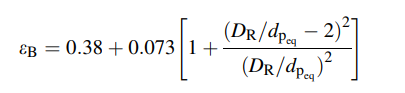

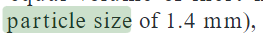

In [121]:
from bvp import OrthogonalCollocation
from kinetics import ft_reactants, effective_reactions

In [122]:
dia_cat = 0.14
n_points = 6
ivp_rtol=1e-16

In [123]:
def bc_eq(r, y, dy, d2y, yb, *args):  #boundary conditions
    return y - yb

def transport_eq(r, y, dy, d2y, yb, *args): #partial equations
    return d2y - ft_reactants(r, y, *args)

In [124]:
collocation = OrthogonalCollocation(
                transport_eq,
                bc_eq,
                n_points, 3, x0=0, x1=dia_cat/2)

In [125]:
def get_bed_fraction(DR, dp):

    return 0.38 + 0.073*(1 + (DR/dp - 2)**2/(DR/dp)**2)

In [126]:
porosity = get_bed_fraction(2.54, 0.254)

In [127]:
def deltarhoP(rho0,P):

    '''Function to get the density of oil corretion with pressure.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in lb/ft^3.
        
        P: int or float
           Pressure in psia.

        Returns
        -------
        deltarhoP: float
                  Density correction with pressure in lb/ft^3.

    '''

    return ((0.167 + (16.181*10**(-0.0425*rho0)))*(P/1000) - 0.01*(0.299 + (263*10**(-0.0603*rho0)))*(P/1000)**2)

def deltarhoT(rho0, P, T):

    '''Function to get the density of oil corretion with temperature.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in lb/ft^3.
        
        P: int or float
           Pressure in psia.
    
        T: int or float
           Temperature in  °R.

        Returns
        -------
        deltarhoT: float
                  Density correction with temperature in lb/ft^3.

    '''

    return ((0.0133 + 152.4*(rho0 + deltarhoP(rho0,P))**(-2.45)))*(T-520) - (8.1*10**(-6) - 0.0622*10**((-0.764)*(rho0 + deltarhoP(rho0,P))))*(T-520)**2


def oil_density(rho0,P,T):

    '''Get the density of oil in function of pressure and temperature.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        oil_density: float
                  Density correction with temperature and pressure in g/cm^3.

    '''    

    rho0 = rho0/16.018
    T = 1.8*T
    P = P*14.7/101325

    return (rho0 + deltarhoP(rho0,P) - deltarhoT(rho0,P,T))*0.016018

In [128]:
V_reactor = Ac*z  #Volume of the reactor
fi = 356 #H2/ Oil Ratio std m3/m3

In [129]:
uL = LHSV/3600*V_reactor/Ac
uG = uL*(1e5/P)*(T/273.15)*fi

In [130]:
GL = uL*oil_density(rho0,P,T)

In [131]:
def mi_L(T,API=API):

      '''Function to get the viscosity of oil.

      Parameters
      ----------
      API: float or int
            API gravity of oil.   

      T: int or float
            Temperature in K.

      Returns
      -------
      mi_L: float
            Viscosity of oil sulfite in g/(cm*s).'''

      T = T*1.8

      a = 10.313*np.log10(T - 460) - 36.447
      return 3.141e10*(T - 460)**(-3.444)*((np.log10(API))**a)/100


def D1L(T = T):

      '''Gets the coefficient of diffusivity of the organic sulfur compound in solution in cm^2/s.

      Parameters
      ----------
      T: int or float
            Temperature in K.

      Returns
      -------
      D1L: float
            The difusivity coefficient.
      '''

      return (8.93e-8*(v1**0.267)*T)/((v1**0.433)*(mi_L(T)*100))

def D2L(T = T):

      '''Gets the coefficient of diffusivity of hydrogen in solution in cm^2/s.

      Parameters
      ----------
      T: int or float
            Temperature in K.

      Returns
      -------
      D2L: float
            The difusivity coefficient.
      '''

      return (8.93e-8*(v1**0.267)*T)/((v2**0.433)*(mi_L(T)*100))

def D4L(T = T):

      '''Gets the coefficient of diffusivity of hydrogen sulfite in solution in cm^2/s.

      Parameters
      ----------
      T: int or float
            Temperature in K.

      Returns
      -------
      D2L: float
            The difusivity coefficient.
    '''

      return 8.93e-8*v1**0.267*T/v4**0.433/(mi_L(T)*100)

In [132]:
def Lambda2(T):

    '''Function to get the solubility of hydrogen in hydrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in K.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen in (Nl H2,)/[(g oil)*(MPa)].
    '''
    T = T - 273.15

    ro_20 = oil_density(rho0,101325,293.15)

    return  (-0.559729 - 0.42947e-3*T + 3.07539e-3*T/ro_20 + 1.94593e-6*T**2 + 0.835783/ro_20**2) 

def Henry_coefficient2_fun(rho0 = rho0, P = P, T = T):

    '''Function to get the Henry coefficient of hydrogen in hydrocarbon mixtures.
     
        rho0: int or float
            Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        H: float
           The Henry coefficient for hydrogen in MPa.cm^3/mol. '''  

    
    return Vn/(Lambda2(T)*oil_density(rho0,P,T)/1000)

def Lambda4(T=T):

   '''Function to get the solubility of hydrogen sulfite in hidrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in °C.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen sulfite in (Nl H2S,)/[(g oil)*(MPa)].
    '''
   T = T - 273.15

   return np.exp(3.3670 - 0.008470*T)

def Henry_coefficient4_fun(rho0 = rho0, P = P, T = T):

    '''Function to get the Henry coefficient of hydrogen sulfite in hydrocarbon mixtures. 

        Parameters
        ----------

        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        H: float
           The Henry coefficient for hydrogen sulfite in MPa.cm^3/mol. '''  

    return Vn/(Lambda4(T)*oil_density(rho0,P,T)/1000)



In [133]:
def k2L_aL_fun(rho0 = rho0, P = P, T = T): 
    
   '''Get the gas-liquid mass transfer coefficient from liquid to particle for hydrogen.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k2Lat: float
             Mass transfer coefficient in s^-1.'''
   
     
   return D2L(T)*alfa1*(GL/mi_L(T))**alfa2*(mi_L(T)/(oil_density(rho0,P,T)*D2L(T)))**(0.5)

def k4L_aL_fun(rho0 = rho0, P = P, T = T): 
    
   '''Get the gas-liquid mass transfer coefficient from liquid to particle for hydrogen sulfite.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k4Lat: float
             Mass transfer coefficient in s^-1.'''
   
     
   return D4L(T)*alfa1*(GL/mi_L(T))**alfa2*(mi_L(T)/(oil_density(rho0,P,T)*D4L(T)))**(0.5)

def aS_fun(dp=dp,porosity = 0.5):

    '''Gets the specific surface area of the packing.

        Parameters
        ----------
        dp: int or float
            Diameter of the pellet in cm.

        porosity: int or float
                  The void fraction of the catalystic bed.

        Return
        ------
        a_super: float
                 The specific surface area of the packing in cm^-1.
    '''

    return 6*(1-porosity)/dp

def k1S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for organic sulfur compound.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k1S: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D1L(T)*aS_fun()*1.8*(GL/(mi_L(T)*aS_fun()))**0.5*(mi_L(T)/(oil_density(rho0,P,T)*D1L(T)))**(1/3)

def k2S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for hydrogen.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k2S: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D2L(T)*aS_fun()*1.8*(GL/(mi_L(T)*aS_fun()))**0.5*(mi_L(T)/(oil_density(rho0,P,T)*D2L(T)))**(1/3)

def k4S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for hydrogen sulfite.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k4sat: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D4L(T) * aS_fun()*1.8 * (GL/(mi_L(T)*aS_fun()))**0.5 * (mi_L(T)/(oil_density(rho0,P,T)*D4L(T)))**(1/3)

In [134]:
H2 = Henry_coefficient2_fun()

H4 = Henry_coefficient4_fun()

In [135]:
w0 = 0.02009 #weigth fraction of sulfur.
w1 = (1284 - 518)*1e-6 #weigth fraction of non basic nitrogen.
w2 = 518*1e-6 #weigth fraction of basic nitrogen.
w3= 0.419 #weigth fraction of aromatic compounds.


rhoL = oil_density(rho0,P,T)

In [136]:
 ## INITIAL  CONCENTRATIONS

cL00 = rhoL*w0/Mm1
cL10 = rhoL*w1/Mm1
cL20 = rhoL*w2/Mm1
cL30 = rhoL*w3/Mm1


In [137]:
pG40 = 5.3
pG50 = 0
cL40 = pG40/H2 #inlet concentration of hydrogen in mol/cm^3 .
cL50 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .
cL60 = 0 #inlet concentration of naphtneses in mol/cm^3 .
z0=0
z=31.54 #length of reactor

## The mass-balance equation for components in the gas phase in the reactor

![Alt text](image-5.png)

Me basear nesse artigo e corrigir as quantidades finais dos compostos aromáticos gerados, não básicos e básicos

In [100]:
k2L_aL = k2L_aL_fun()


k4L_aL = k4L_aL_fun()


k1S_aS = k1S_fun()*aS_fun()


k2S_aS = k2S_fun()*aS_fun()


k4S_aS = k4S_fun()*aS_fun()

In [138]:
def mass_balance_gas_phase2(p2G, C2L, uG = uG, R=8.3145, T = T):

    return - k2L_aL * (p2G / H2 - C2L) * R * T / uG 

def mass_balance_gas_phase4(p4G, C4L, uG = uG, R=8.3145, T = T):

    return - k4L_aL * (p4G / H4- C4L) * R * T / uG

def mass_balance_gas_liquid_phase2(p2G, C2L, C2S, uL = uL):

    return (k2L_aL * (p2G / H2 - C2L) -  k2S_aS * (C2L - C2S)) / uL

def mass_balance_gas_liquid_phase4(p4G, C4L, C4S, uL = uL):
    
    return (k4L_aL * (p4G / H4 - C4L) -  k4S_aS * (C4L - C4S)) / uL

def mass_balance_liquid(C1L, C1S, uL = uL): 

    return - (C1L - C1S) * k1S_aS / uL

In [139]:
'''def constraints(C,variables, z):

    #C: concentration of solid components.
    
    ni0 = -1
    ni1 = -1
    ni2 = 1
    ni3 = -1
    ni4 = -15
    ni5 = 9
    ni6 = 1

    eff= 1

    
    F = np.empty((7))
    F[0] =  - ni0*eff*rhob * rHDS(C,T)  -  k1S_aS*(variables[0] - C[0])
    F[1] =  - ni1*eff*rhob * rHDN_NB(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[1] - C[1])
    F[2] =  - ni2*eff*rhob * rHDN_B(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[2] - C[2])
    F[3] =  - ni3*eff*rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[3] - C[3])
    F[4] =  - ni4*rhob *eff*rHDS(C,T)   - k2S_aS * (variables[4] - C[4])
    F[5] =  - ni5*rhob *eff*rHDS(C,T)   - k4S_aS * (variables[5] - C[5])
    F[6] =  - ni6*eff*rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[6] - C[6])

    return F'''

'def constraints(C,variables, z):\n\n    #C: concentration of solid components.\n    \n    ni0 = -1\n    ni1 = -1\n    ni2 = 1\n    ni3 = -1\n    ni4 = -15\n    ni5 = 9\n    ni6 = 1\n\n    eff= 1\n\n    \n    F = np.empty((7))\n    F[0] =  - ni0*eff*rhob * rHDS(C,T)  -  k1S_aS*(variables[0] - C[0])\n    F[1] =  - ni1*eff*rhob * rHDN_NB(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[1] - C[1])\n    F[2] =  - ni2*eff*rhob * rHDN_B(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[2] - C[2])\n    F[3] =  - ni3*eff*rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[3] - C[3])\n    F[4] =  - ni4*rhob *eff*rHDS(C,T)   - k2S_aS * (variables[4] - C[4])\n    F[5] =  - ni5*rhob *eff*rHDS(C,T)   - k4S_aS * (variables[5] - C[5])\n    F[6] =  - ni6*eff*rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[6] - C[6])\n\n    return F'

In [140]:
def constraints(C,variables, z):
    
    ni0 = -1
    ni1 = -1
    ni2 = 1
    ni3 = -1
    ni4 = -15
    ni5 = 9
    ni6 = 1

    if z == 0:

        root_method = 'lm'
        C[C == 0] = ivp_rtol
        y0 = np.column_stack((C,) * (n_points + 1))

    else:
        y0 = collocation.y
        root_method = 'hybr'

    args_ft = (C, variables[7], T)
    collocation.collocate(y0, args=args_ft, method=root_method)

    args_reactions = (variables[7], T)
    eff = collocation.effectiveness(effective_reactions, args_reactions)

    print(eff)

    
    F = np.empty((7))
    F[0] =  - ni0*eff[0] * rhob * rHDS(C,T)  -  k1S_aS*(variables[0] - C[0])
    F[1] =  - ni1*eff[1] * rhob * rHDN_NB(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[1] - C[1])
    F[2] =  - ni2*eff[2] * rhob * rHDN_B(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[2] - C[2])
    F[3] =  - ni3*eff[3] * rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[3] - C[3])
    F[4] =  - ni4*rhob * eff[0] * rHDS(C,T)   - k2S_aS * (variables[4] - C[4])
    F[5] =  - ni5*rhob * eff[0] * rHDS(C,T)   - k4S_aS * (variables[5] - C[5])
    F[6] =  - ni6*eff[3]*rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[6] - C[6])

    return F        

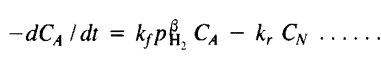

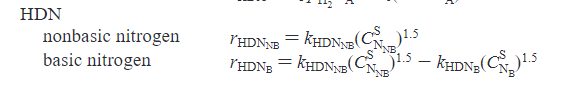

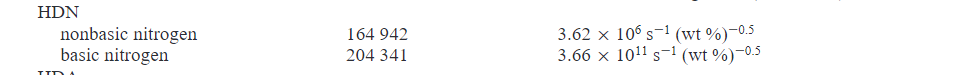

Depois testar também balanço para o naftaleno

## Resolver daqui para baixo outro dia

In [141]:
def dy(z, variables):

    cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG4, pG5 = variables
    
    if z==z0:
        solid_concentrations = root(constraints, [cL00, cL10, cL20, cL30, cL40, cL50, cL60], ([cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG40], z), method = "lm").x

    else:
        solid_concentrations = root(constraints, [cL0,  cL1, cL2, cL3, cL4, cL5, cL6], ([cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG4], z),  method = "lm").x



    return np.array([mass_balance_liquid(cL0, solid_concentrations[0]),
     mass_balance_liquid(cL1, solid_concentrations[1]),
     mass_balance_liquid(cL2, solid_concentrations[2]),
     mass_balance_liquid(cL3, solid_concentrations[3]),     
     mass_balance_gas_liquid_phase2(pG4, cL4, solid_concentrations[4]),
     mass_balance_gas_liquid_phase4(pG5, cL5, solid_concentrations[5]),
     mass_balance_liquid(cL6, solid_concentrations[6]),
     mass_balance_gas_phase2(pG4, cL4),
     mass_balance_gas_phase4(pG5, cL5)])

In [142]:
t_span = [z0, z]
t_eval = np.linspace(0, z, 1000)
y0 = [cL00, cL10, cL20, cL30, cL40, cL50, cL60, pG40, pG50]

In [144]:
sol = solve_ivp(dy, t_span=t_span, y0=y0, t_eval=t_eval, method = "RK45")

[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.9997558 1.        1.        0.9999998]
[0.99993618 1.         1.         0.9999998 ]
[0.99995007 1.         1.         0.9999998 ]
[0.99995165 1.         1.         0.9999998 ]
[0.99995224 1.         1.         0.9999998 ]
[0.99995251 1.         1.         0.9999998 ]
[0.99995266 1.         1.         0.9999998 ]
[0.99995266 1.         1.         0.9999998 ]
[0.99995266 1.         1.         0.9999998 ]
[0.99995266 1.         1.         0.9999998 ]
[0.99995266 1.         1.         0.9999998 ]
[0.99995266 1.         1.         0.99

KeyboardInterrupt: 

![Alt text](image-3.png)

![Alt text](image-4.png)

In [107]:
cL0_fun,  cL1_fun, cL2_fun, cL3_fun, cL4_fun, cL5_fun, cL6_fun, p4G_fun, p5G_fun = sol.y

In [108]:
import matplotlib.pyplot as plt

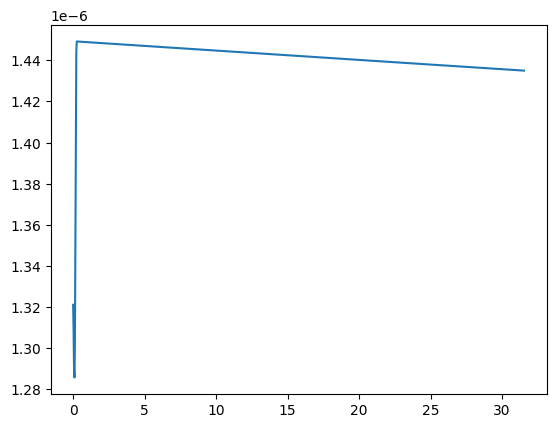

In [109]:
z_lin = np.linspace(0,z,1000)
plt.plot(z_lin,cL1_fun)

In [110]:
p4G_fun

array([5.3       , 5.29999722, 5.29998725, 5.29996932, 5.29994483,
       5.29991738, 5.29989273, 5.29987886, 5.29988061, 5.29988036,
       5.29987561, 5.29986651, 5.29985323, 5.29983592, 5.29981474,
       5.29978981, 5.29976128, 5.29972934, 5.29969411, 5.29965569,
       5.29961417, 5.29956964, 5.29952218, 5.29947189, 5.29941885,
       5.29936315, 5.29930486, 5.29924407, 5.29918086, 5.29911531,
       5.29904749, 5.29897748, 5.29890536, 5.2988312 , 5.29875507,
       5.29867704, 5.29859718, 5.29851555, 5.29843223, 5.29834728,
       5.29826076, 5.29817273, 5.29808326, 5.29799239, 5.2979002 ,
       5.29780672, 5.29771196, 5.29761597, 5.29751876, 5.29742037,
       5.29732081, 5.29722013, 5.29711834, 5.29701548, 5.29691157,
       5.29680663, 5.2967007 , 5.2965938 , 5.29648595, 5.29637719,
       5.29626754, 5.29615702, 5.29604567, 5.2959335 , 5.29582055,
       5.29570683, 5.29559238, 5.29547722, 5.29536137, 5.29524486,
       5.29512771, 5.29500996, 5.29489161, 5.29477271, 5.29465

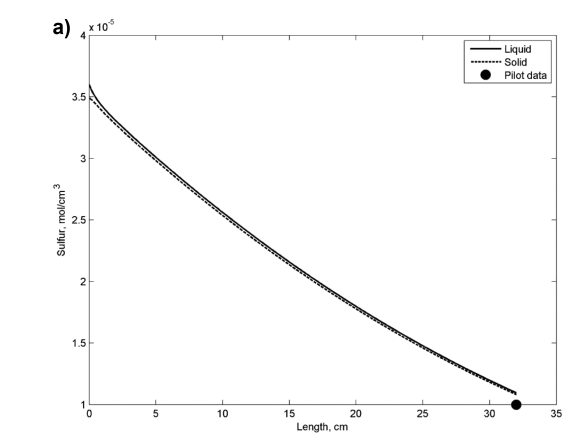

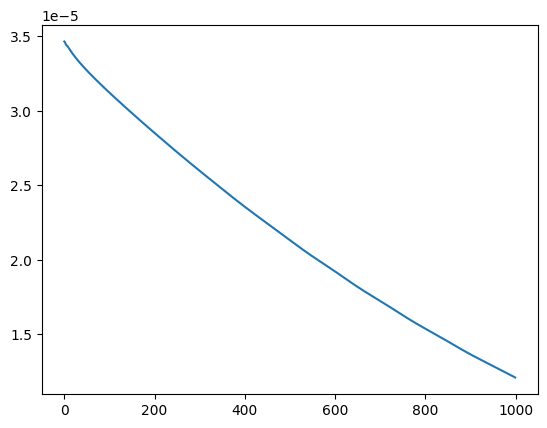

In [111]:
plt.plot(cL0_fun)
plt.show()

In [112]:
cL0_fun

array([3.46472868e-05, 3.46179578e-05, 3.45528412e-05, 3.44820961e-05,
       3.44242357e-05, 3.43861278e-05, 3.43629946e-05, 3.43384124e-05,
       3.42928518e-05, 3.42445371e-05, 3.41971328e-05, 3.41505867e-05,
       3.41048498e-05, 3.40598765e-05, 3.40156244e-05, 3.39720546e-05,
       3.39291300e-05, 3.38867908e-05, 3.38450042e-05, 3.38037525e-05,
       3.37630180e-05, 3.37227834e-05, 3.36830312e-05, 3.36437445e-05,
       3.36049062e-05, 3.35664997e-05, 3.35285082e-05, 3.34909155e-05,
       3.34537052e-05, 3.34168613e-05, 3.33803679e-05, 3.33442092e-05,
       3.33083697e-05, 3.32728341e-05, 3.32375870e-05, 3.32026135e-05,
       3.31678987e-05, 3.31334279e-05, 3.30991867e-05, 3.30651605e-05,
       3.30313353e-05, 3.29976971e-05, 3.29642321e-05, 3.29309265e-05,
       3.28977671e-05, 3.28647626e-05, 3.28319208e-05, 3.27992386e-05,
       3.27667129e-05, 3.27343406e-05, 3.27021184e-05, 3.26700433e-05,
       3.26381120e-05, 3.26063214e-05, 3.25746682e-05, 3.25431491e-05,
      

In [113]:
cL6_fun

array([0.00000000e+00, 1.20054205e-07, 4.55143501e-07, 9.62444107e-07,
       1.59218051e-06, 2.28762546e-06, 2.98509997e-06, 3.61397333e-06,
       4.12842743e-06, 4.62668826e-06, 5.12451339e-06, 5.62190281e-06,
       6.11885649e-06, 6.61537444e-06, 7.11145667e-06, 7.60710323e-06,
       8.10231414e-06, 8.59708928e-06, 9.09142870e-06, 9.58533256e-06,
       1.00788010e-05, 1.05718342e-05, 1.10644322e-05, 1.15565954e-05,
       1.20483237e-05, 1.25396174e-05, 1.30304767e-05, 1.35209017e-05,
       1.40108927e-05, 1.45004496e-05, 1.49895729e-05, 1.54782626e-05,
       1.59665189e-05, 1.64543420e-05, 1.69417321e-05, 1.74286895e-05,
       1.79152142e-05, 1.84013065e-05, 1.88869666e-05, 1.93721947e-05,
       1.98569910e-05, 2.03413557e-05, 2.08252891e-05, 2.13087913e-05,
       2.17918625e-05, 2.22745031e-05, 2.27567133e-05, 2.32384935e-05,
       2.37198439e-05, 2.42007650e-05, 2.46812569e-05, 2.51613199e-05,
       2.56409545e-05, 2.61201610e-05, 2.65989395e-05, 2.70772905e-05,
      

In [114]:
cL1_fun

array([1.32104637e-06, 1.30839222e-06, 1.28970295e-06, 1.28566126e-06,
       1.30592573e-06, 1.34913081e-06, 1.40288681e-06, 1.44377996e-06,
       1.44921623e-06, 1.44920181e-06, 1.44918739e-06, 1.44917297e-06,
       1.44915855e-06, 1.44914413e-06, 1.44912971e-06, 1.44911529e-06,
       1.44910087e-06, 1.44908646e-06, 1.44907204e-06, 1.44905762e-06,
       1.44904320e-06, 1.44902879e-06, 1.44901437e-06, 1.44899995e-06,
       1.44898554e-06, 1.44897112e-06, 1.44895670e-06, 1.44894229e-06,
       1.44892787e-06, 1.44891346e-06, 1.44889904e-06, 1.44888463e-06,
       1.44887021e-06, 1.44885580e-06, 1.44884138e-06, 1.44882697e-06,
       1.44881255e-06, 1.44879814e-06, 1.44878373e-06, 1.44876931e-06,
       1.44875490e-06, 1.44874049e-06, 1.44872607e-06, 1.44871166e-06,
       1.44869725e-06, 1.44868284e-06, 1.44866843e-06, 1.44865401e-06,
       1.44863960e-06, 1.44862519e-06, 1.44861078e-06, 1.44859637e-06,
       1.44858196e-06, 1.44856755e-06, 1.44855314e-06, 1.44853873e-06,
      

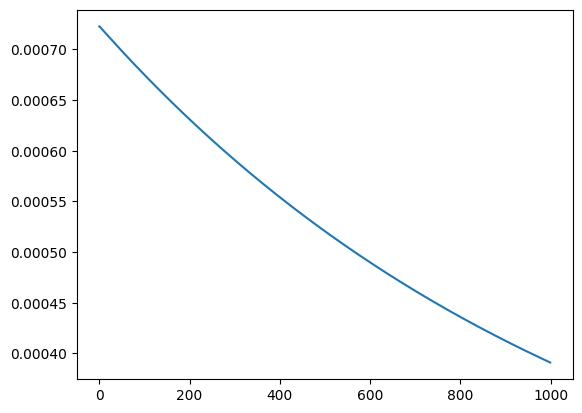

In [115]:
plt.plot(cL3_fun)
plt.show()


## Cálculo da efetividade

In [116]:
from scipy.integrate import solve_bvp
from scipy.integrate import romberg, quad

Estudar conteúdo desse link: https://stackoverflow.com/questions/60293084/scipy-solve-bvp-problem-2nd-order-diff-eq

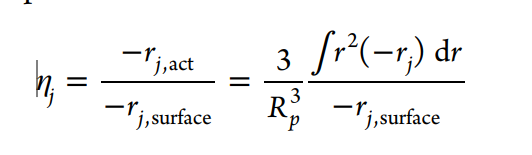